# Checking out Quandl/Zillow Real Estate API

In [1]:
import pandas as pd
import numpy as np
import quandl
import re
from lib import quandl_api_key

"""
This is a notebook for automating exploration of Zillow Real Estate data from Quandl.
As I learn more about Jupyter widgets, there will be updates. For now, check out how
I got it done.
"""
quandl.ApiConfig.api_key = quandl_api_key

def load_df():
    data = pd.DataFrame()
    zillow_codes = pd.read_csv('ZILLOW_metadata.csv.zip', compression='zip', usecols=['code', 'name'])
    return zillow_codes

In [2]:
#This function is based on user ganprad's get_df function from https://github.com/ganprad/rentorbuy/blob/master/rentorbuy.ipynb
def get_df(df,col='code'):
    ''' 
    Function takes in Zillow Metadata, and parses code column
    for specific string and codes.
    '''
    metro = r'\bM\w+' #Finding values in code that begin with M. I.E., Metropolitan areas.
    indices = [i for i,val in enumerate(df[col].str.findall(metro)) if val != []]
    return df.iloc[indices,:]

In [3]:
# Let's load our df in.
metro_df = get_df(load_df(),col='code')

In [4]:
# Extract the name of the metropolitan area. Be sure to clean further. There are sure to be issues with some names, such as Española.
metro_df.name.values[:] = metro_df.loc[:,'name'].apply(lambda x: x.split('-')[-1].strip())

In [5]:
# And let's see it.
metro_df.sample(5)

,code,name
1898988,M1014_MPPRAH,"Angola, IN"
1987679,M744_ZTTY,"Helena, AR"
1927254,M183_ISA_BT_IMTP,"Crestview, FL"
1903021,M108_MLPBT,"Kalamazoo, MI"
1966321,M517_MDLNSAH,"Midland, MI"


In [6]:
#A function to return a dataframe with codes corresponding to a specific metropolitan area.
def get_metro(m_area):
    m_query = f'name == "{m_area}"'
    m_city = metro_df.query(m_query)
    return m_city

In [7]:
#Let's try Chicago first.
m_chicago = get_metro("Chicago, IL")
m_chicago.sample(5, random_state=123)

,code,name
1952516,M3_SCSAM,"Chicago, IL"
1952506,M3_PLPRMT,"Chicago, IL"
1952519,M3_SCTTM,"Chicago, IL"
1952524,M3_SPTTM,"Chicago, IL"
1952419,M3_DOZP,"Chicago, IL"


<AxesSubplot:xlabel='Date'>

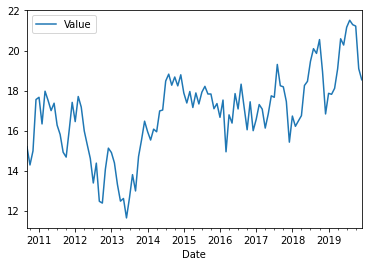

In [8]:
# Alright, it works. Now, let's try to retrieve and plot data from quandl using a random code from our Chicago df.
rng = np.random.default_rng()
c_chicago = rng.choice(m_chicago.code.values)
sample_c_chicago = quandl.get('ZILLOW/'+c_chicago)
sample_c_chicago.plot()

In [9]:
# Okay, looks good. Next, let's try to specify the indicator. We'll start by loading and inspecting the csv.
indicators = pd.read_csv('indicators.csv', delimiter='|')
indicators.head()

,INDICATOR,CODE
0,Age of Inventory (Public),AOIP
1,Buyer Seller Index,BSI
2,Days on Zillow (Public),DOZP
3,Home Sales (NSA),SALES
4,Home Sales (SA),SASALES


In [10]:
# So, I'm thinking. Two parter. Zillow codes run: ZILLOW/{Metro Area Code}_{Indicator Code}. That is, "ZILLOW/M3_SCSAM".
# To create this, I need a function that produces a metro area code and another that produces an indicator code
# Then, of course, one to bring it all together. We'll deal with the hangups as we go.

# Since it's hard to know what code means what, and tedious to type out metropolitan area names, let's use widgets.

import ipywidgets as widgets
from IPython.display import display


# First, we'll need some functions to create lists, to in turn to create tuples for
# use in the options paramter of widgets.Dropdown()


# We'll start with metropolitan areas. First, let's create a function to return a list of all
# the unique metropolitan areas. So, we'll eventually pass metro_df['name'] through it.

def unique_sorted_values(array):
    unique = array.unique().tolist()
    unique.sort()
    return unique

# Next, we'll create a function to search for corresponding metro codes in metro_df['code']. This will
# select a random row from the specified metropolitan area and using it to return its exact code.
# Recall, metropolitan codes and indicator codes are joined by an underscore ('_'), so we'll need to
# seperate them when we get our random row. We will return the first item of the list created
# through use of the Split method.

def get_metro_code(m_area):
    m_query = f'name == "{m_area}"'
    m_city = metro_df.query(m_query)
    m_city_code = rng.choice(m_city.code.values).split('_')[0]
    return m_city_code


# Now that we have a way to get our specific city code, let's create a function to
# make a list out of these codes for our eventual tuple.

def metro_code_list(m_list):
    m_codes = []
    for code in m_list:
        m_codes.append(get_metro_code(code))
    return m_codes

# Done and done. Now, let's run those functions in a zip and covert to list for our list of tuples.
m_names = unique_sorted_values(metro_df['name'])
code_names = zip(unique_sorted_values(metro_df['name']), metro_code_list(m_names))
code_names_list = list(code_names)


# Now is time for the widget. Let's pass our list of tuples through the options parameter.
dropdown_code_names = widgets.Dropdown(
    options=code_names_list,
    description='Name:',
    disabled=False
)

# Alright, now let's use widget.Dropdown()'s observe method to take note of changes
# from when we reselect options. Got the Lambda function with the help of the lovely 
# folk over at StackOverflow.

dropdown_code_names.observe(
    lambda c: plot_content(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)
# And display.
display(dropdown_code_names)

Dropdown(description='Name:', options=(('?ola, NM', 'M1559'), ('?on City, CO', 'M1301'), ('Aberdeen, NC', 'M97…

In [18]:
# Let's select Chicago again, since we are aware of the result. Should begin with 'M3'
# We'll use the value attribute...
w_name = dropdown_code_names.value
w_name

'M3'

In [12]:
# That worked! Now, let's do the same for indicators.
# The indicators df is a lot neater, so there's little to nothing to be done in advance.
# Let's create our tuple and see what gives.

ind_code = zip(indicators['INDICATOR'], indicators['CODE'])
ind_code_list = list(ind_code)

dropdown_ind = widgets.Dropdown(
    options=ind_code_list,
    description='Indicator:',
    disabled=False
)

dropdown_ind.observe(
    lambda c: plot_content(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)

display(dropdown_ind)

Dropdown(description='Indicator:', options=(('Age of Inventory (Public)', 'AOIP'), ('Buyer Seller Index', 'BSI…

In [19]:
# Looks good. We'll set it to Home Sales and assign the value to w_ind.
w_ind = dropdown_ind.value
w_ind

'SASALES'

In [20]:
# That looks good too! Alright, now let's make a function to return a df based
# on our selections of Chicago and Home Sales

def get_data(m,w):
    return quandl.get(f"ZILLOW/{m}_{w}")
m_chicago_home_sales = get_data(w_name, w_ind)
m_chicago_home_sales.head()

,Value
Date,
2008-06-30,8237.0
2008-07-31,8485.0
2008-08-31,8390.0
2008-09-30,7904.0
2008-10-31,7499.0


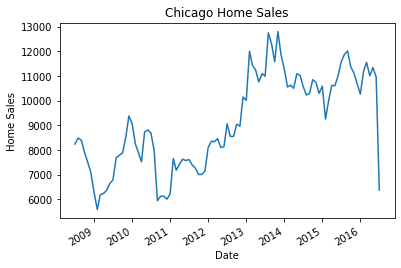

In [21]:
# Worked again! We're on a streak. Let's plot it.
import matplotlib.pyplot as plt

# And we'll go ahead and create a function while we're at it, whether we use it again or not.
def plot_timeseries(axes, xy, title, xlabel, ylabel):
    axes.plot(xy)
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    fig.autofmt_xdate()
    

fig, ax = plt.subplots()
plot_timeseries(ax, m_chicago_home_sales, 'Chicago Home Sales', 'Date', 'Home Sales')

In [16]:
# Now, let's link things up. The goal will be a plot that changes as 
# we modify selections from either dropdown list.

# Let's create output instances
output = widgets.Output()
plot_output = widgets.Output()

# Let's initialize new dropdowns, just to avoid trouble.
dd_c_names = widgets.Dropdown(
    options=code_names_list,
    description='Name:',
    value='M3',
    disabled=False
)
dd_ind_codes = widgets.Dropdown(
    options=ind_code_list,
    description='Indicator:',
    value='SASALES',
    disabled=False
)

# Okay, let's create a function to handle our output
def zillow_select(metro, ind):
    
    # We'll start with the clear_output method to take care of old selections
    output.clear_output()
    plot_output.clear_output()
    
    # And, using 'with output:', we'll capture everything we want to display
    with output:
        
        # First, the code, both to see if things work as intended
        # and to have on hand for a manual search in case things go wrong
        print(f'ZILLOW/{metro}_{ind}')
        
        # Then, some error handling. This block will needed because we are
        # generating codes rather than selecting them from our metro_df.
        # Because of that, there's a chance we request a df from Zillow/Quandl
        # that does not actually exist.
        try:
            selected_df = get_data(metro, ind)
            display(selected_df.head())
        except:
            print('The information you requested does not exist.')
    with plot_output:
        # Okay, let's run it back.
        try:
            selected_df.plot()
            plt.show()
        except:
            print('The visualization you requested cannot be created.')
    

# Now, for event handling. We have two dropdowns to pay attention to with our observe method,
# so we will need functions for either. Inside, we will be running our zillow_select function
# backwards and fowards with the dropdowns swapped
def dd_c_eventhandler(change):
    zillow_select(change.new, dd_ind_codes.value)
    
def dd_ind_eventhandler(change):
    zillow_select(dd_c_names.value, change.new)
    
# And so we observe.
dd_c_names.observe(dd_c_eventhandler, names='value')
dd_ind_codes.observe(dd_ind_eventhandler, names='value')

# And display our dropdowns
input_widgets = widgets.HBox([dd_c_names, dd_ind_codes])
display(input_widgets)

In [17]:
# And, tabs. Because why not? Remember to select the 'Plot' tab to check out the graph.
tab = widgets.Tab([output, plot_output])
tab.set_title(0, 'Dataframe')
tab.set_title(1, 'Plot')
display(tab)

### In the future, there are a few specific things I want/need to do.
- Switch over the usage of metro_df for the dropdown lists, no longer generating codes that could return a 404. It'll probably all be prettier that way as well.
- Annotate plots automatically. Will likely have to enrich metro_df towards this end.
- Look into options for interactive plots.
- Clean names containing special symbols. The dropdowns alone might already reveal some issues.
- Jupyter Widgets seem more versatile that I had known. Will enrich displays and options as I learn more.
- Add predictive analytics.